**Authored by:** Dushyant Singh Hada  



import libraries

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

important functions

In [36]:
import math

def wilson(x1, v1, v2, a12, a21, temp):
    # Bound x1 to avoid log(0)
    x1 = min(max(x1, 1e-12), 1-1e-12)
    x2 = 1 - x1
    
    delta12 = (v2/v1)*math.exp(-a12/(8.314*temp))
    delta21 = (v1/v2)*math.exp(-a21/(8.314*temp))

    ln_gamma1 = -math.log(x1 + x2*delta12) + x2*((delta12/(x1 + x2*delta12)) - (delta21/(x2 + x1*delta21)))
    ln_gamma2 = -math.log(x2 + x1*delta21) - x1*((delta12/(x1 + x2*delta12)) - (delta21/(x2 + x1*delta21)))

    return math.exp(ln_gamma1), math.exp(ln_gamma2)


def nrtl(x1, b12, b21, alpha, temp):
    # Bound x1
    x1 = min(max(x1, 1e-12), 1-1e-12)
    x2 = 1 - x1

    tau12 = b12/(8.314*temp)
    tau21 = b21/(8.314*temp)

    g12 = math.exp(-alpha * tau12)
    g21 = math.exp(-alpha * tau21)

    # Correct NRTL equations
    ln_gamma1 = x2**2 * (tau21 * (g21 / (x1 + x2*g21))**2 + (g12 * tau12) / (x2 + x1*g12)**2)
    ln_gamma2 = x1**2 * (tau12 * (g12 / (x2 + x1*g12))**2 + (g21 * tau21) / (x1 + x2*g21)**2)

    return math.exp(ln_gamma1), math.exp(ln_gamma2)


def vap_pressure(A, B, C, temp):
    # Antoine expects Celsius
    T_C = temp - 273.15
    ln_psat = A - B / (T_C + C)
    return math.exp(ln_psat)


def boiling_pt(A, B, C, psat):
    # returns Kelvin
    T_C = B / (A - math.log(psat)) - C
    return T_C + 273.15


initializing data

In [37]:
component1 = "Methanol"
component2 = "Acetonitrile"
print(component1,component2)
required = ["v1","v2","a12","a21","b12","b21","alpha", "A1","B1","C1","A2","B2","C2"]
values = {}

values = {
    'v1': 40.73*1e-3, 
    'v2': 66.30*1e-3, 
    'a12': 1219.5, 
    'a21': 823.8,
    'b12': 1439, 
    'b21': 1317.1, 
    'alpha': 0.2981,
    'A1': 16.5785,  
    'B1': 3638.27, 
    'C1': 239.500, 
    'A2': 14.8950, 
    'B2': 3413.10,
    'C2': 250.523
}



Methanol Acetonitrile


12.12

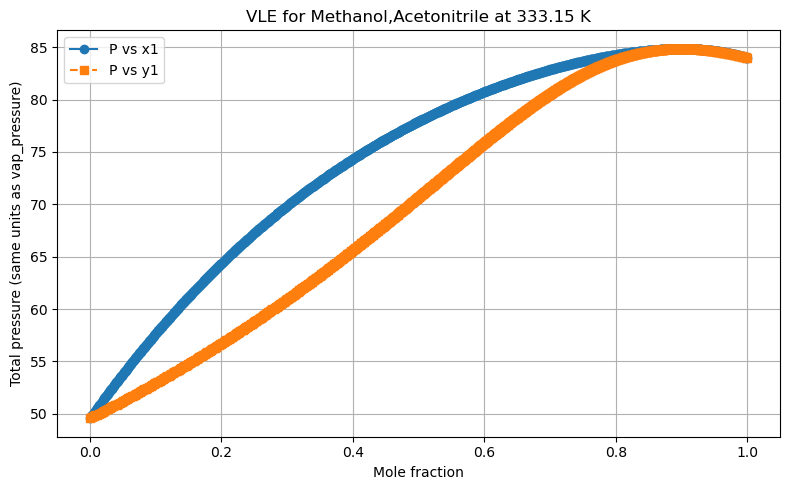

           x1        y1   pressure
0    0.000000  0.000000  49.577825
1    0.001001  0.002780  49.666285
2    0.002002  0.005546  49.754587
3    0.003003  0.008299  49.842730
4    0.004004  0.011038  49.930715
..        ...       ...        ...
995  0.995996  0.995112  84.065218
996  0.996997  0.996325  84.046602
997  0.997998  0.997544  84.027711
998  0.998999  0.998769  84.008543
999  1.000000  1.000000  83.989096

[1000 rows x 3 columns]


In [38]:
temp = 333.15

p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], temp)
p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], temp)

x1 = np.linspace(0, 1, num=1000)
gamma1 = [wilson(x, values["v1"], values["v2"], values["a12"], values["a21"], temp)[0] for x in x1]
gamma2 = [wilson(x, values["v1"], values["v2"], values["a12"], values["a21"], temp)[1] for x in x1]

pb = [ x1[i]*gamma1[i]*p1sat + (1-x1[i])*p2sat*gamma2[i] for i in range(len(x1)) ]
y1 = [(x1[i]*p1sat*gamma1[i])/pb[i] for i in range(len(x1))]
result = pd.DataFrame({"x1":x1, "y1":y1 , "pressure":pb})

plt.figure(figsize=(8,5))
plt.plot(x1, pb, marker='o', linestyle='-', label='P vs x1')
plt.plot(y1, pb, marker='s', linestyle='--', label='P vs y1')
plt.xlabel('Mole fraction')
plt.ylabel('Total pressure (same units as vap_pressure)')
plt.title(f'VLE for {component1},{component2} at {temp:.2f} K')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print(result)

12.13

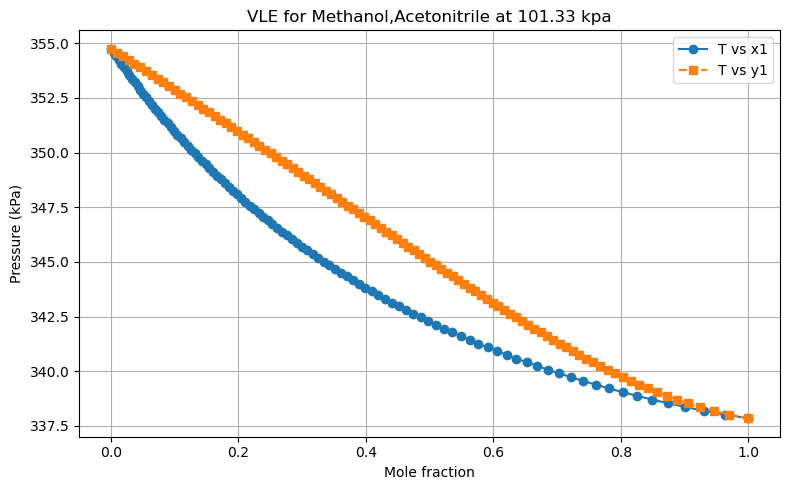

              x1            y1  temperature
0   1.000000e+00  1.000000e+00   337.850189
1   9.630529e-01  9.702866e-01   338.020893
2   9.308319e-01  9.458653e-01   338.191597
3   9.016621e-01  9.246757e-01   338.362302
4   8.747133e-01  9.056998e-01   338.533006
..           ...           ...          ...
95  1.611092e-02  3.668717e-02   354.067083
96  1.201214e-02  2.754848e-02   354.237788
97  7.961246e-03  1.838792e-02   354.408492
98  3.957455e-03  9.205183e-03   354.579196
99  1.044673e-16  2.447106e-16   354.749900

[100 rows x 3 columns]


In [39]:
p = 101.33
t1sat = boiling_pt(values["A1"], values["B1"], values["C1"], p)
t2sat = boiling_pt(values["A2"], values["B2"], values["C2"], p)

temp = np.linspace(t1sat, t2sat, 100)

p1sat = [ vap_pressure(values["A1"], values["B1"], values["C1"], temp[i]) for i in range(len(temp))]
p2sat = [ vap_pressure(values["A2"], values["B2"], values["C2"], temp[i]) for i in range(len(temp))]

for i in range(10):
    if i==0:
        gamma2 = gamma1 = 1
        x1 = [(p - gamma2 * p2sat[i]) / (gamma1 * p1sat[i] - gamma2 * p2sat[i]) for i in range(len(temp)) ]
    else:
        gamma1 = [wilson(x1[i], values["v1"], values["v2"], values["a12"], values["a21"], temp[i]+273.15)[0] for i in range(len(temp))] 
        gamma2 = [wilson(x1[i], values["v1"], values["v2"], values["a12"], values["a21"], temp[i]+273.15)[1] for i in range(len(temp)) ] 
        x1 = [(p - gamma2[i] * p2sat[i]) / (gamma1[i] * p1sat[i] - gamma2[i] * p2sat[i]) for i in range(len(temp)) ]

y1 = [x1[i]*p1sat[i]*gamma1[i]/p for i in range(len(temp))]
result = pd.DataFrame({"x1":x1, "y1":y1 , "temperature":temp})
plt.figure(figsize=(8,5))
plt.plot(x1, temp, marker='o', linestyle='-', label='T vs x1')
plt.plot(y1, temp, marker='s', linestyle='--', label='T vs y1')
plt.xlabel('Mole fraction')
plt.ylabel('Pressure (kPa)')
plt.title(f'VLE for {component1},{component2} at {p:.2f} kpa')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print(result)

12.14

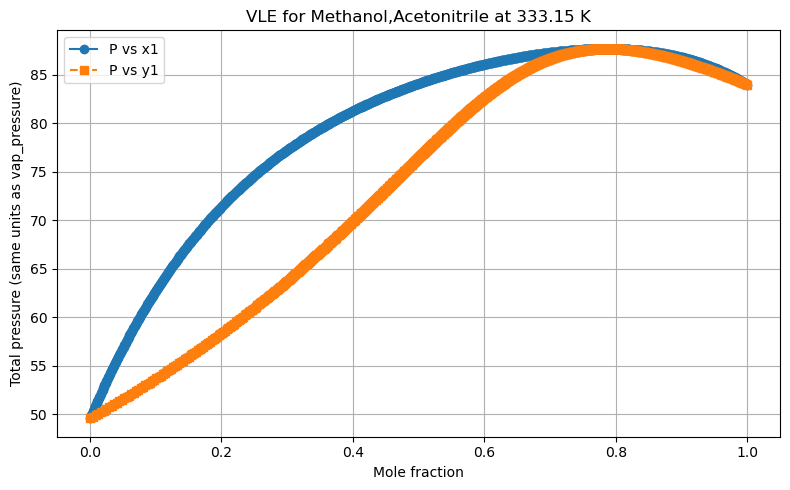

           x1        y1   pressure
0    0.000000  0.000000  49.577825
1    0.001001  0.004236  49.738923
2    0.002002  0.008429  49.899332
3    0.003003  0.012579  50.059054
4    0.004004  0.016688  50.218093
..        ...       ...        ...
995  0.995996  0.994054  84.154460
996  0.996997  0.995530  84.113600
997  0.997998  0.997013  84.072420
998  0.998999  0.998503  84.030919
999  1.000000  1.000000  83.989096

[1000 rows x 3 columns]


In [40]:
temp = 333.15

p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], temp)
p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], temp)

x1 = np.linspace(0, 1, num=1000)
gamma1 = [nrtl(x, values["b12"], values["b21"], values["alpha"], temp)[0] for x in x1]
gamma2 = [nrtl(x, values["b12"], values["b21"], values["alpha"], temp)[1] for x in x1]

pb = [ x1[i]*gamma1[i]*p1sat + (1-x1[i])*p2sat*gamma2[i] for i in range(len(x1)) ]
y1 = [(x1[i]*p1sat*gamma1[i])/pb[i] for i in range(len(x1))]
result = pd.DataFrame({"x1":x1, "y1":y1 , "pressure":pb})

plt.figure(figsize=(8,5))
plt.plot(x1, pb, marker='o', linestyle='-', label='P vs x1')
plt.plot(y1, pb, marker='s', linestyle='--', label='P vs y1')
plt.xlabel('Mole fraction')
plt.ylabel('Total pressure (same units as vap_pressure)')
plt.title(f'VLE for {component1},{component2} at {temp:.2f} K')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print(result)

12.15

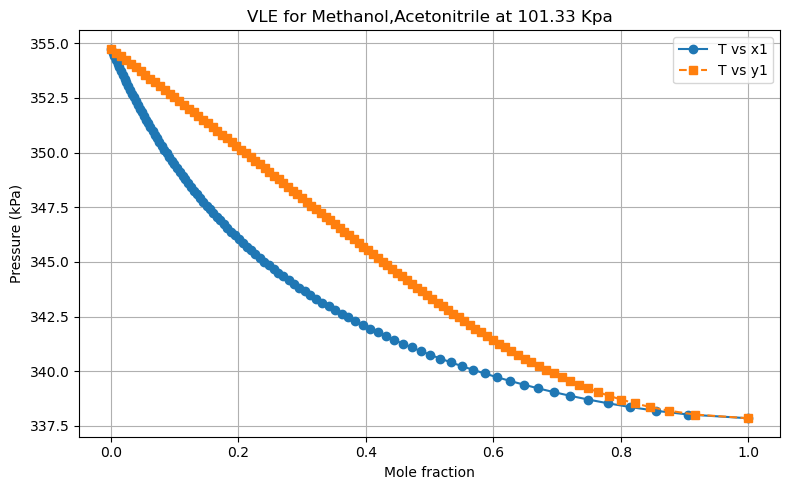

          x1        y1  temperature
0   1.000000  1.000000   337.850189
1   0.905899  0.916272   338.020893
2   0.855161  0.876344   338.191597
3   0.814894  0.846572   338.362302
4   0.780256  0.822042   338.533006
..       ...       ...          ...
95  0.010293  0.030974   354.067083
96  0.007663  0.023259   354.237788
97  0.005072  0.015525   354.408492
98  0.002517  0.007772   354.579196
99  0.000000  0.000000   354.749900

[100 rows x 3 columns]


In [41]:
p = 101.33
t1sat = boiling_pt(values["A1"], values["B1"], values["C1"], p)
t2sat = boiling_pt(values["A2"], values["B2"], values["C2"], p)

temp = np.linspace(t1sat, t2sat, 100)

p1sat = [ vap_pressure(values["A1"], values["B1"], values["C1"], temp[i]) for i in range(len(temp))]
p2sat = [ vap_pressure(values["A2"], values["B2"], values["C2"], temp[i]) for i in range(len(temp))]

for i in range(10):
    if i==0:
        gamma2 = gamma1 = 1
        x1 = [(p - gamma2 * p2sat[i]) / (gamma1 * p1sat[i] - gamma2 * p2sat[i]) for i in range(len(temp)) ]
    else:
        gamma1 = [nrtl(x1[i], values["b12"], values["b21"], values["alpha"], temp[i]+273.15)[0] for i in range(len(temp))] 
        gamma2 = [nrtl(x1[i], values["b12"], values["b21"], values["alpha"], temp[i]+273.15)[1] for i in range(len(temp)) ] 
        x1 = [(p - gamma2[i] * p2sat[i]) / (gamma1[i] * p1sat[i] - gamma2[i] * p2sat[i]) for i in range(len(temp)) ]

y1 = [x1[i]*p1sat[i]*gamma1[i]/p for i in range(len(temp))]
result = pd.DataFrame({"x1":x1, "y1":y1 , "temperature":temp})
plt.figure(figsize=(8,5))
plt.plot(x1, temp, marker='o', linestyle='-', label='T vs x1')
plt.plot(y1, temp, marker='s', linestyle='--', label='T vs y1')
plt.xlabel('Mole fraction')
plt.ylabel('Pressure (kPa)')
plt.title(f'VLE for {component1},{component2} at {p:.2f} Kpa')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print(result)

12.16

(a) bubble pressure is 69.87200853870786 kpa and y1 is 0.4843605505480949
(b) dew pressure  is 60.94313117662234 kpa and x1 is 0.14651315278326044
(c) Optimal vapor fraction (V) ≈ 0.49049 and x1 is 0.20923943172579054, y1 is 0.3942798556154543


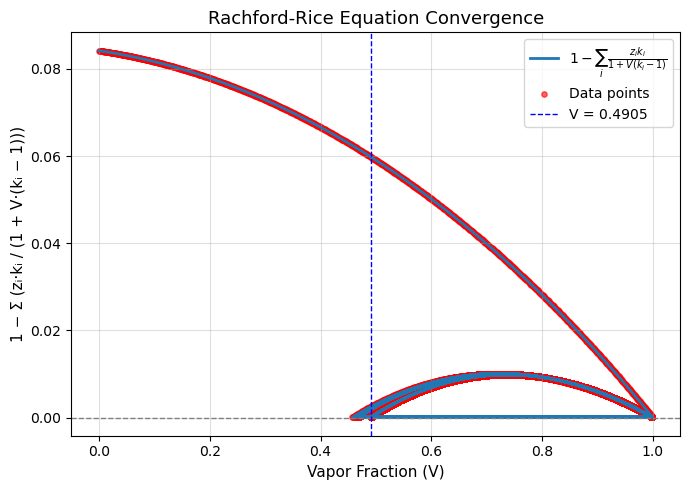

(d) azeotrope formation takes place at : 0.8998998998998999


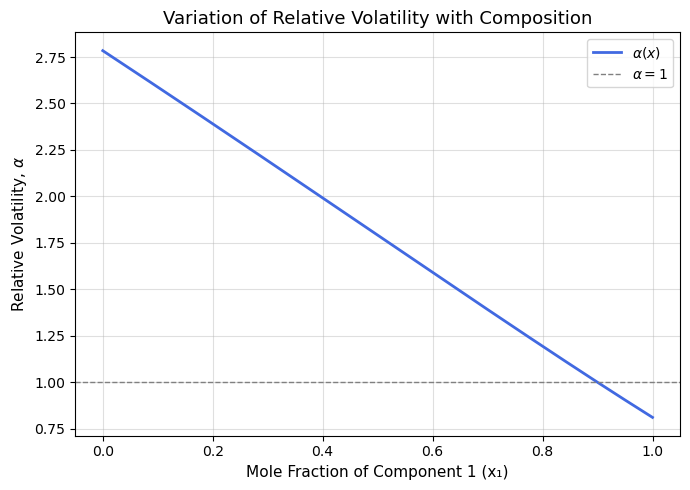

In [68]:
temp = 333.15
# (a)
x1 = 0.3
p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], temp)
p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], temp)
gamma1, gamma2 = wilson(x1, values["v1"], values["v2"], values["a12"], values["a21"], temp)
pb = x1*p1sat*gamma1 + (1-x1)*p2sat*gamma2
y1=x1*p1sat*gamma1/pb
print(f"(a) bubble pressure is {pb} kpa and y1 is {y1}")

# (b)
y1 = 0.3
for i in range(10):
    if i==0:
        gamma2 = gamma1 = 1
        p_dew = 1/(y1/(gamma1*p1sat) + (1-y1)/(gamma2*p2sat))
        x1 = (y1*p_dew)/(p1sat*gamma1)
    else:
        gamma1, gamma2 = wilson(x1, values["v1"], values["v2"], values["a12"], values["a21"], temp)
        p_dew = 1/(y1/(gamma1*p1sat) + (1-y1)/(gamma2*p2sat))
        x1 = (y1*p_dew)/(p1sat*gamma1)
print(f"(b) dew pressure  is {p_dew} kpa and x1 is {x1}")

# (c)
t_flash = 333.15
p_flash = (pb + p_dew) / 2
p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], t_flash)
p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], t_flash)
z1 = 0.3
v_value = []
summa = []

for i in range(100):
    gamma1, gamma2 = wilson(x1, values["v1"], values["v2"], values["a12"], values["a21"], t_flash) if i!=0 else (1,1)
    k1, k2 = gamma1*p1sat/p_flash, gamma2*p2sat/p_flash
    prev = float("inf")
    for v in np.linspace(0,1,1000):
        if v==1:
            continue
        summation = z1*k1/(1+v*(k1-1)) + (1-z1)*k2/(1+v*(k2-1))
        if summation>1:
            continue
        v_value.append(v)
        summa.append(1-summation)
        if abs(summation-1) < prev:
            prev = abs(summation-1)
            y1 = z1*k1/(1+v*(k1-1))
            x1 = (p_flash*y1)/(p1sat*gamma1)
            ans_v = v
            # break
print(f"(c) Optimal vapor fraction (V) ≈ {ans_v:.5f} and x1 is {x1}, y1 is {y1}")

plt.figure(figsize=(7, 5))
plt.plot(v_value, summa, label=r'$1 - \sum_i \frac{z_i k_i}{1 + V(k_i - 1)}$', linewidth=2)
plt.scatter(v_value, summa, s=15, color='red', alpha=0.6, label="Data points")

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(ans_v, color='blue', linestyle='--', linewidth=1, label=f'V = {ans_v:.4f}')

plt.title("Rachford-Rice Equation Convergence", fontsize=13)
plt.xlabel("Vapor Fraction (V)", fontsize=11)
plt.ylabel("1 − Σ (zᵢ·kᵢ / (1 + V·(kᵢ − 1)))", fontsize=11)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


# (d)
x_vals = []
def alpha_func(x1,p1sat,p2sat):
    gamma1, gamma2 = wilson(x1, values["v1"], values["v2"], values["a12"], values["a21"], temp)
    return gamma1*p1sat/(gamma2*p2sat)


prev = float("inf")
x_vals, alpha_vals = [], []

for x in np.linspace(0,1,1000):
    
    alpha = alpha_func(x,p1sat,p2sat)
    x_vals.append(x)
    alpha_vals.append(alpha)

    if abs(alpha-1)<1e-3:
        ans_x = x
        
        # break

if (alpha_func(0,p1sat,p2sat)-1)*(alpha_func(1,p1sat,p2sat)-1)<0:    
    print("(d) azeotrope formation takes place at :",ans_x)
else:
    print("(d) azeotope is not formed at given T and P conditions for any value of x")

plt.figure(figsize=(7, 5))
plt.plot(x_vals, alpha_vals, color='royalblue', linewidth=2, label=r'$\alpha(x)$')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1, label=r'$\alpha = 1$')

plt.title("Variation of Relative Volatility with Composition", fontsize=13)
plt.xlabel("Mole Fraction of Component 1 (x₁)", fontsize=11)
plt.ylabel(r"Relative Volatility, $\alpha$", fontsize=11)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


12.17

(a) bubble pressure is 77.25459169079633 kpa and y1 is 0.5121171796952748
(b) dew pressure  is 63.74822359512907 kpa and x1 is 0.10991075169300965
(c) Optimal vapor fraction (V) ≈ 0.50651 and x1 is 0.18740545786887303, y1 is 0.4097017969775605


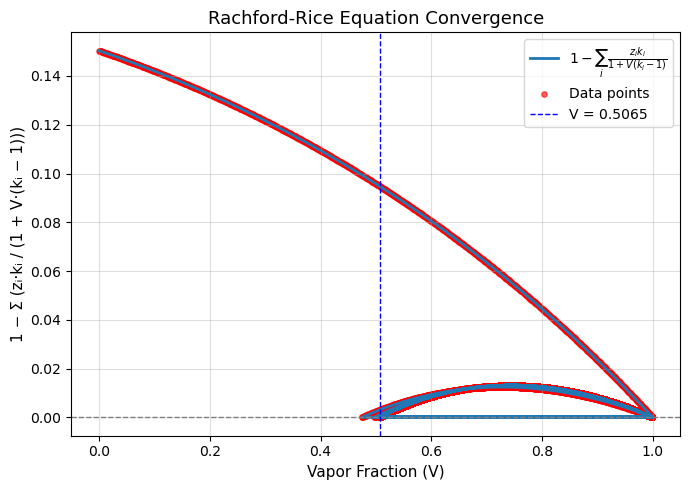

(d) azeotrope formation takes place at : 0.7867867867867868


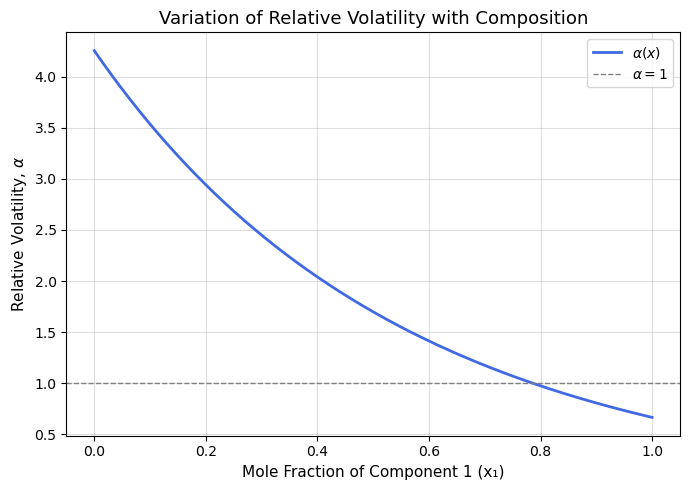

In [70]:
temp = 333.15
# (a)
x1 = 0.3
p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], temp)
p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], temp)
gamma1, gamma2 = nrtl(x1, values["b12"], values["b21"], values["alpha"], temp)
pb = x1*p1sat*gamma1 + (1-x1)*p2sat*gamma2
y1=x1*p1sat*gamma1/pb
print(f"(a) bubble pressure is {pb} kpa and y1 is {y1}")

# (b)
y1 = 0.3
for i in range(10):
    if i==0:
        gamma2 = gamma1 = 1
        p_dew = 1/(y1/(gamma1*p1sat) + (1-y1)/(gamma2*p2sat))
        x1 = (y1*p_dew)/(p1sat*gamma1)
    else:
        gamma1, gamma2 = nrtl(x1, values["b12"], values["b21"], values["alpha"], temp)
        p_dew = 1/(y1/(gamma1*p1sat) + (1-y1)/(gamma2*p2sat))
        x1 = (y1*p_dew)/(p1sat*gamma1)
print(f"(b) dew pressure  is {p_dew} kpa and x1 is {x1}")

# (c)
t_flash = 333.15
p_flash = (pb + p_dew) / 2
p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], t_flash)
p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], t_flash)
z1 = 0.3
v_value = []
summa = []

for i in range(100):
    gamma1, gamma2 = nrtl(x1, values["b12"], values["b21"], values["alpha"], temp) if i!=0 else (1,1)
    k1, k2 = gamma1*p1sat/p_flash, gamma2*p2sat/p_flash
    prev = float("inf")
    for v in np.linspace(0,1,1000):
        if v==1:
            continue
        summation = z1*k1/(1+v*(k1-1)) + (1-z1)*k2/(1+v*(k2-1))
        if summation>1:
            continue
        v_value.append(v)
        summa.append(1-summation)
        if abs(summation-1) < prev:
            prev = abs(summation-1)
            y1 = z1*k1/(1+v*(k1-1))
            x1 = (p_flash*y1)/(p1sat*gamma1)
            ans_v = v
            # break
print(f"(c) Optimal vapor fraction (V) ≈ {ans_v:.5f} and x1 is {x1}, y1 is {y1}")

plt.figure(figsize=(7, 5))
plt.plot(v_value, summa, label=r'$1 - \sum_i \frac{z_i k_i}{1 + V(k_i - 1)}$', linewidth=2)
plt.scatter(v_value, summa, s=15, color='red', alpha=0.6, label="Data points")

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(ans_v, color='blue', linestyle='--', linewidth=1, label=f'V = {ans_v:.4f}')

plt.title("Rachford-Rice Equation Convergence", fontsize=13)
plt.xlabel("Vapor Fraction (V)", fontsize=11)
plt.ylabel("1 − Σ (zᵢ·kᵢ / (1 + V·(kᵢ − 1)))", fontsize=11)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


# (d)
x_vals = []
def alpha_func(x1,p1sat,p2sat):
    gamma1, gamma2 = nrtl(x1, values["b12"], values["b21"], values["alpha"], temp)
    return gamma1*p1sat/(gamma2*p2sat)


prev = float("inf")
x_vals, alpha_vals = [], []

for x in np.linspace(0,1,1000):
    
    alpha = alpha_func(x,p1sat,p2sat)
    x_vals.append(x)
    alpha_vals.append(alpha)

    if abs(alpha-1)<1e-3:
        ans_x = x
        
        # break

if (alpha_func(0,p1sat,p2sat)-1)*(alpha_func(1,p1sat,p2sat)-1)<0:    
    print("(d) azeotrope formation takes place at :",ans_x)
else:
    print("(d) azeotope is not formed at given T and P conditions for any value of x")

plt.figure(figsize=(7, 5))
plt.plot(x_vals, alpha_vals, color='royalblue', linewidth=2, label=r'$\alpha(x)$')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1, label=r'$\alpha = 1$')

plt.title("Variation of Relative Volatility with Composition", fontsize=13)
plt.xlabel("Mole Fraction of Component 1 (x₁)", fontsize=11)
plt.ylabel(r"Relative Volatility, $\alpha$", fontsize=11)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


12.18

(a) bubble temperature is 333.23394530001167 kelvin and y1 is 0.3351022747656323
(b) dew temperature is 347.98672791782303 kelvin and x1 is 0.13927808527042046
(c) Optimal vapor fraction (V) ≈ 0.99900 ,x1 is 0.18821319932678263,y1 is 0.3001120108223178


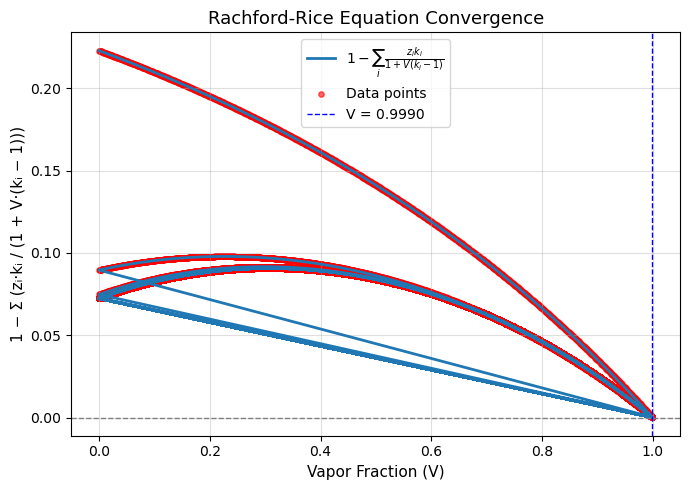

(d)Azeotrope formation occurs near x₁ = 0.9169 and temperature 337.6659


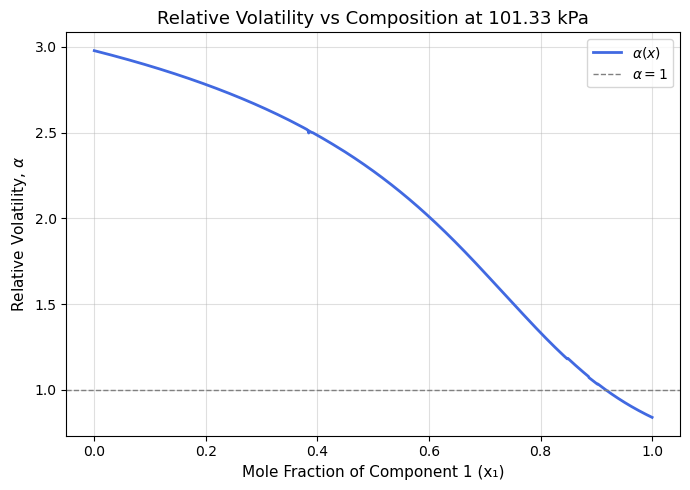

In [101]:
p = 101.33
# (a)
x1 = 0.3
t1sat = boiling_pt(values["A1"], values["B1"], values["C1"], p)
t2sat = boiling_pt(values["A2"], values["B2"], values["C2"], p)
t_avg = 0.5*(t1sat+t2sat)
temp = t_avg
temp_old = 0

while abs(temp-temp_old) > 0.001:
    p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], temp)
    p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], temp)

    gamma1, gamma2 = wilson(x1, values["v1"], values["v2"], values["a12"], values["a21"], temp)

    relative_volatility = p1sat/p2sat
    p1sat = p*(x1*gamma1 + (1-x1)*gamma2/relative_volatility)

    temp_old = temp
    temp = boiling_pt(values["A1"], values["B1"], values["C1"], p1sat)
tb = temp
y1 = x1*gamma1*p1sat/p
print(f"(a) bubble temperature is {tb} kelvin and y1 is {y1}")

# (b)
y1 = 0.3
t1sat = boiling_pt(values["A1"], values["B1"], values["C1"], p)
t2sat = boiling_pt(values["A2"], values["B2"], values["C2"], p)
t_avg = 0.5*(t1sat+t2sat)
temp = t_avg
temp_old = 0
gamma1, gamma2 = 1, 1
while abs(temp-temp_old) > 0.001:
    p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], temp)
    p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], temp)

    p_dew = 1/(y1/(gamma1*p1sat) + (1-y1)/(gamma2*p2sat))

    x1 = y1*p_dew/(p1sat*gamma1)
    x2 = 1-x1

    gamma1, gamma2 = wilson(x1, values["v1"], values["v2"], values["a12"], values["a21"], temp)

    relative_volatility = p1sat/p2sat
    p1sat = p*(y1/gamma1 + ((1-y1)*relative_volatility)/gamma2)

    temp_old = temp
    temp = boiling_pt(values["A1"], values["B1"], values["C1"], p1sat)
td = temp
print(f"(b) dew temperature is {temp} kelvin and x1 is {x1}")

# (c)
t_flash = 0.5*(tb+td)
p_flash = p

p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], t_flash)
p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], t_flash)
v_value,summa = [],[]
z1 = 0.3
k1, k2 = p1sat/p_flash, p2sat/p_flash

for i in range(100):
    gamma1, gamma2 =wilson(x1, values["v1"], values["v2"], values["a12"], values["a21"], t_flash) if i!=0 else (1,1)

    k1, k2 = gamma1*p1sat/p_flash, gamma2*p2sat/p_flash
    prev = float("inf")
    for v in np.linspace(0,1,1000):
        if v==1:
            continue
        summation = z1*k1/(1+v*(k1-1)) + (1-z1)*k2/(1+v*(k2-1))
        if summation>1:
            continue
        v_value.append(v)
        summa.append(1-summation)
        if abs(summation-1) < prev:
            prev = abs(summation-1)
            y1 = z1*k1/(1+v*(k1-1))
            x1 = (p_flash*y1)/(p1sat*gamma1)
            ans_v = v
            # break
    # print(x1)
print(f"(c) Optimal vapor fraction (V) ≈ {ans_v:.5f} ,x1 is {x1},y1 is {y1}")

plt.figure(figsize=(7, 5))
plt.plot(v_value, summa, label=r'$1 - \sum_i \frac{z_i k_i}{1 + V(k_i - 1)}$', linewidth=2)
plt.scatter(v_value, summa, s=15, color='red', alpha=0.6, label="Data points")

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(ans_v, color='blue', linestyle='--', linewidth=1, label=f'V = {ans_v:.4f}')

plt.title("Rachford-Rice Equation Convergence", fontsize=13)
plt.xlabel("Vapor Fraction (V)", fontsize=11)
plt.ylabel("1 − Σ (zᵢ·kᵢ / (1 + V·(kᵢ − 1)))", fontsize=11)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# (d)

def alpha_func(x1, A1, B1, C1, A2, B2, C2, temp):
    """
    Computes relative volatility α = (γ1 * P1sat) / (γ2 * P2sat)
    using Wilson activity coefficients.
    """
    gamma1, gamma2 = wilson(x1, values["v1"], values["v2"], values["a12"], values["a21"], temp)
    p1sat = vap_pressure(A1, B1, C1, temp)
    p2sat = vap_pressure(A2, B2, C2, temp)
    return gamma1 * p1sat / (gamma2 * p2sat)



x_vals, alpha_vals = [], []
prev = float("inf")

# Compute α(x)
for y1 in np.linspace(0, 1, 1000):

    t1sat = boiling_pt(values["A1"], values["B1"], values["C1"], p)
    t2sat = boiling_pt(values["A2"], values["B2"], values["C2"], p)
    t_avg = 0.5*(t1sat+t2sat)
    temp = t_avg
    temp_old = 0
    gamma1, gamma2 = 1, 1
    while abs(temp-temp_old) > 0.001:
        p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], temp)
        p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], temp)

        p_dew = 1/(y1/(gamma1*p1sat) + (1-y1)/(gamma2*p2sat))

        x1=(y1*p_dew/(gamma1*p1sat))
       

        gamma1, gamma2 = wilson(x1, values["v1"], values["v2"], values["a12"], values["a21"], temp)

        relative_volatility = p1sat/p2sat
        p1sat = p*(y1/gamma1 + ((1-y1)*relative_volatility)/gamma2)

        temp_old = temp
        temp = boiling_pt(values["A1"], values["B1"], values["C1"], p1sat)
    td = temp

    alpha = alpha_func(x1,values["A1"], values["B1"], values["C1"], values["A2"], values["B2"], values["C2"], td)
    x_vals.append(y1)
    alpha_vals.append(alpha)

    if abs(alpha - 1) < prev:
        prev = abs(alpha - 1)
        azeo_x = y1
        azeo_t = td

# Azeotrope condition check
if (alpha_func(0, values["A1"], values["B1"], values["C1"], values["A2"], values["B2"], values["C2"], temp)-1) * (alpha_func(1,values["A1"], values["B1"], values["C1"], values["A2"], values["B2"], values["C2"], temp)-1) < 0:
    print(f"(d)Azeotrope formation occurs near x₁ = {azeo_x:.4f} and temperature {azeo_t:.4f}")
else:
    print("(d)No azeotrope is formed at the given T and P conditions.")

# Plotting
plt.figure(figsize=(7, 5))
plt.plot(x_vals, alpha_vals, color='royalblue', linewidth=2, label=r'$\alpha(x)$')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1, label=r'$\alpha = 1$')

plt.title(f"Relative Volatility vs Composition at {p:.2f} kPa", fontsize=13)
plt.xlabel("Mole Fraction of Component 1 (x₁)", fontsize=11)
plt.ylabel(r"Relative Volatility, $\alpha$", fontsize=11)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()



12.19

(a) bubble temperature is 335.4577561701821 kelvin and y1 is 0.42456956122439904
(b) dew temperature is 346.65655152124634 kelvin and x1 is 0.10403925457043833
(c) Optimal vapor fraction (V) ≈ 0.16617 ,x1 is 0.2600633290022887,y1 is 0.5004051020547801


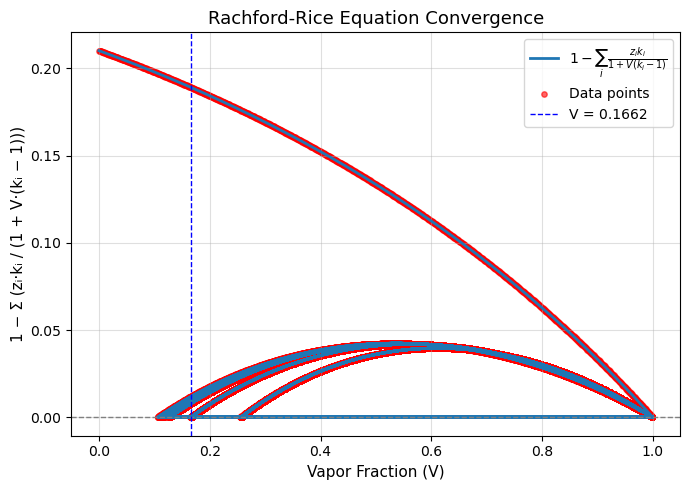

(d)Azeotrope formation occurs near x₁ = 0.8038 and temperature 336.9428


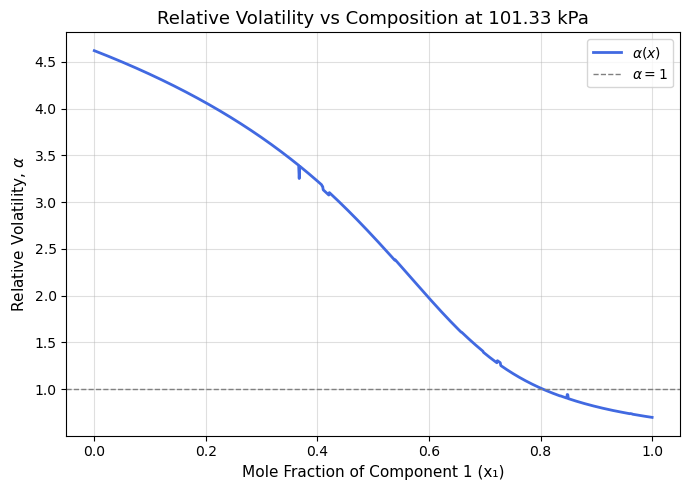

In [98]:
p = 101.33
# (a)
x1 = 0.3
t1sat = boiling_pt(values["A1"], values["B1"], values["C1"], p)
t2sat = boiling_pt(values["A2"], values["B2"], values["C2"], p)
t_avg = 0.5*(t1sat+t2sat)
temp = t_avg
temp_old = 0

while abs(temp-temp_old) > 0.001:
    p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], temp)
    p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], temp)

    gamma1, gamma2 = nrtl(x1, values["b12"], values["b21"], values["alpha"], t_flash)

    relative_volatility = p1sat/p2sat
    p1sat = p*(x1*gamma1 + (1-x1)*gamma2/relative_volatility)

    temp_old = temp
    temp = boiling_pt(values["A1"], values["B1"], values["C1"], p1sat)
tb = temp
y1 = x1*gamma1*p1sat/p
print(f"(a) bubble temperature is {temp} kelvin and y1 is {y1}")

# (b)
y1 = 0.3
t1sat = boiling_pt(values["A1"], values["B1"], values["C1"], p)
t2sat = boiling_pt(values["A2"], values["B2"], values["C2"], p)
t_avg = 0.5*(t1sat+t2sat)
temp = t_avg
temp_old = 0
gamma1, gamma2 = 1, 1
while abs(temp-temp_old) > 0.001:
    p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], temp)
    p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], temp)

    p_dew = 1/(y1/(gamma1*p1sat) + (1-y1)/(gamma2*p2sat))

    x1 = y1*p_dew/(p1sat*gamma1)
    x2 = 1-x1

    gamma1, gamma2 = nrtl(x1, values["b12"], values["b21"], values["alpha"], t_flash)

    relative_volatility = p1sat/p2sat
    p1sat = p*(y1/gamma1 + ((1-y1)*relative_volatility)/gamma2)

    temp_old = temp
    temp = boiling_pt(values["A1"], values["B1"], values["C1"], p1sat)
td = temp
print(f"(b) dew temperature is {temp} kelvin and x1 is {x1}")

# (c)
t_flash = 0.5*(tb+td)
p_flash = p

p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], t_flash)
p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], t_flash)
v_value,summa = [],[]
z1 = 0.3
k1, k2 = p1sat/p_flash, p2sat/p_flash

for i in range(100):
    gamma1, gamma2 =nrtl(x1, values["b12"], values["b21"], values["alpha"], t_flash) if i!=0 else (1,1)

    k1, k2 = gamma1*p1sat/p_flash, gamma2*p2sat/p_flash
    prev = float("inf")
    for v in np.linspace(0,1,1000):
        if v==1:
            continue
        summation = z1*k1/(1+v*(k1-1)) + (1-z1)*k2/(1+v*(k2-1))
        if summation>1:
            continue
        v_value.append(v)
        summa.append(1-summation)
        if abs(summation-1) < prev:
            prev = abs(summation-1)
            y1 = z1*k1/(1+v*(k1-1))
            x1 = (p_flash*y1)/(p1sat*gamma1)
            ans_v = v
            # break
    # print(x1)
print(f"(c) Optimal vapor fraction (V) ≈ {ans_v:.5f} ,x1 is {x1},y1 is {y1}")

plt.figure(figsize=(7, 5))
plt.plot(v_value, summa, label=r'$1 - \sum_i \frac{z_i k_i}{1 + V(k_i - 1)}$', linewidth=2)
plt.scatter(v_value, summa, s=15, color='red', alpha=0.6, label="Data points")

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(ans_v, color='blue', linestyle='--', linewidth=1, label=f'V = {ans_v:.4f}')

plt.title("Rachford-Rice Equation Convergence", fontsize=13)
plt.xlabel("Vapor Fraction (V)", fontsize=11)
plt.ylabel("1 − Σ (zᵢ·kᵢ / (1 + V·(kᵢ − 1)))", fontsize=11)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


# (d)

def alpha_func(x1, A1, B1, C1, A2, B2, C2, temp):
    """
    Computes relative volatility α = (γ1 * P1sat) / (γ2 * P2sat)
    using Wilson activity coefficients.
    """
    gamma1, gamma2 = nrtl(x1, values["b12"], values["b21"], values["alpha"], t_flash)
    p1sat = vap_pressure(A1, B1, C1, temp)
    p2sat = vap_pressure(A2, B2, C2, temp)
    return gamma1 * p1sat / (gamma2 * p2sat)



x_vals, alpha_vals = [], []
prev = float("inf")

# Compute α(x)
for y1 in np.linspace(0, 1, 1000):

    t1sat = boiling_pt(values["A1"], values["B1"], values["C1"], p)
    t2sat = boiling_pt(values["A2"], values["B2"], values["C2"], p)
    t_avg = 0.5*(t1sat+t2sat)
    temp = t_avg
    temp_old = 0
    gamma1, gamma2 = 1, 1
    while abs(temp-temp_old) > 0.001:
        p1sat = vap_pressure(values["A1"], values["B1"], values["C1"], temp)
        p2sat = vap_pressure(values["A2"], values["B2"], values["C2"], temp)

        p_dew = 1/(y1/(gamma1*p1sat) + (1-y1)/(gamma2*p2sat))

        x1=(y1*p_dew/(gamma1*p1sat))
       

        gamma1, gamma2 = nrtl(x1, values["b12"], values["b21"], values["alpha"], t_flash)

        relative_volatility = p1sat/p2sat
        p1sat = p*(y1/gamma1 + ((1-y1)*relative_volatility)/gamma2)

        temp_old = temp
        temp = boiling_pt(values["A1"], values["B1"], values["C1"], p1sat)
    td = temp

    alpha = alpha_func(x1,values["A1"], values["B1"], values["C1"], values["A2"], values["B2"], values["C2"], td)
    x_vals.append(y1)
    alpha_vals.append(alpha)

    if abs(alpha - 1) < prev:
        prev = abs(alpha - 1)
        azeo_x = y1
        azeo_t = td

# Azeotrope condition check
if (alpha_func(0, values["A1"], values["B1"], values["C1"], values["A2"], values["B2"], values["C2"], temp)-1) * (alpha_func(1,values["A1"], values["B1"], values["C1"], values["A2"], values["B2"], values["C2"], temp)-1) < 0:
    print(f"(d)Azeotrope formation occurs near x₁ = {azeo_x:.4f} and temperature {azeo_t:.4f}")
else:
    print("(d)No azeotrope is formed at the given T and P conditions.")

# Plotting
plt.figure(figsize=(7, 5))
plt.plot(x_vals, alpha_vals, color='royalblue', linewidth=2, label=r'$\alpha(x)$')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1, label=r'$\alpha = 1$')

plt.title(f"Relative Volatility vs Composition at {p:.2f} kPa", fontsize=13)
plt.xlabel("Mole Fraction of Component 1 (x₁)", fontsize=11)
plt.ylabel(r"Relative Volatility, $\alpha$", fontsize=11)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()



functions for ternery system

In [46]:
import math

def wilson_ternary(x, v, a, temp):
    """
    Wilson model for 3-component system
    
    Parameters:
        x   : list of mole fractions [x1, x2, x3]
        v   : list of molar liquid volumes [v1, v2, v3]
        a   : 3x3 matrix of interaction energies a_ij (i≠j), diagonal ignored
        temp: temperature (K)
        
    Returns:
        gamma: list of activity coefficients [gamma1, gamma2, gamma3]
    """
    
    # numerical safety for mole fractions
    x = [max(min(xi, 1 - 1e-12), 1e-12) for xi in x]
    
    R = 8.314
    
    # compute Lambda_ij terms
    Lambda = [[0.0]*3 for _ in range(3)]
    for i in range(3):
        for j in range(3):
            if i != j:
                Lambda[i][j] = (v[j]/v[i]) * math.exp(-a[i][j]/(R*temp))
            else:
                Lambda[i][j] = 1.0  # convention

    ln_gamma = [0.0]*3
    
    # compute ln(gamma_i)
    for i in range(3):
        sum1 = sum(x[j] * Lambda[i][j] for j in range(3))
        term1 = 1 - math.log(sum1)
        
        term2 = 0
        for j in range(3):
            sum2 = sum(x[k] * Lambda[j][k] for k in range(3))
            term2 += x[j] * (Lambda[j][i] / sum2)
        
        ln_gamma[i] = term1 - term2
    
    # convert to gamma
    gamma = [math.exp(val) for val in ln_gamma]
    
    return gamma


import math

def nrtl_ternary(x, b, alpha, temp):
    """
    Extended NRTL model for a ternary system.

    Parameters
    ----------
    x : list or tuple of length 3
        Mole fractions [x1, x2, x3]
    b : 3x3 nested list
        Interaction parameters b_ij in J/mol (b[i][i] ignored)
    alpha : 3x3 nested list
        Non-randomness parameters alpha_ij (usually between 0.2 and 0.47)
    temp : float
        Temperature in Kelvin

    Returns
    -------
    gamma : list of floats
        Activity coefficients [γ1, γ2, γ3]
    """
    R = 8.314
    n = 3
    x = [max(min(xi, 1 - 1e-12), 1e-12) for xi in x]  # avoid log(0)
    
    # Compute tau and G matrices
    tau = [[0]*n for _ in range(n)]
    G = [[0]*n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j:
                tau[i][j] = b[i][j] / (R * temp)
                G[i][j] = math.exp(-alpha[i][j] * tau[i][j])
            else:
                tau[i][j] = 0
                G[i][j] = 1

    ln_gamma = [0.0]*n
    for i in range(n):
        sum1 = 0.0
        sum2 = 0.0
        denom_i = sum(x[k] * G[k][i] for k in range(n))
        for j in range(n):
            denom_j = sum(x[k] * G[k][j] for k in range(n))
            term1 = (x[j] * tau[j][i] * G[j][i]) / denom_i
            term2 = (x[j] * G[i][j]) / denom_j * (tau[i][j] - sum(x[m] * tau[m][j] * G[m][j] for m in range(n)) / denom_j)
            sum1 += term1
            sum2 += term2
        ln_gamma[i] = sum1 + sum2

    gamma = [math.exp(val) for val in ln_gamma]
    return gamma


data for ternary questions

In [47]:
'''
1 is acetone
2 is methanol
3 is water
'''
a_ij = [[None,-677.8,1219.5],
       [2441.4,None,449.6],
       [6062.5,1965.9,None]]

b_ij = [[None,773.3,2642.1],
        [932.1,None,-1062.9],
        [5013.3,3538.7,None]]

alpha_ij = [[None,0.3084,0.5343],
            [0.3084,None,0.2994],
            [0.5343,0.2994,None]]

v1,v2,v3 = 74.05*1e-3, 40.73*1e-3, 18.07*1e-3

A1,B1,C1 = 14.3145, 2756.22, 228.060
A2,B2,C2 = 16.5785, 3638.27, 239.500
A3,B3,C3 = 16.3872, 3885.7, 230.170

12.20

(a) bubble pressure for ternary syatem at 338.15 is 117.12068302526228 kpa
(b) dew pressure for ternary syatem at 338.15 is 69.13774766646652 kpa
(c) Optimal vapor fraction (V) ≈ 0.67668


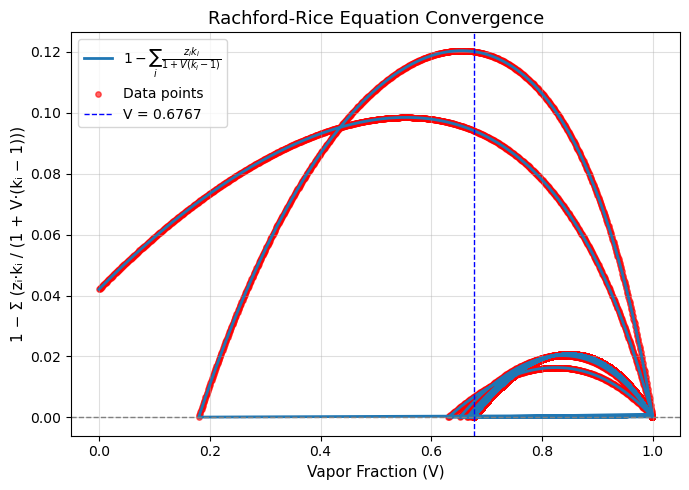

In [77]:
# (a)
temp = 338.15
x1 = 0.3
x2 = 0.4
x3 = 1-x1-x2

gamma1,gamma2,gamma3 = wilson_ternary([x1,x2,x3],[v1,v2,v3],a_ij,temp)
p1sat,p2sat,p3sat = vap_pressure(A1,B1,C1,temp),vap_pressure(A2,B2,C2,temp),vap_pressure(A3,B3,C3,temp)
pb = x1*gamma1*p1sat + x2*p2sat*gamma2 + x3*p3sat*gamma3
print(f"(a) bubble pressure for ternary syatem at {temp} is {pb} kpa")


# (b)
y1 = 0.3
y2 = 0.4
y3 = 1-y2-y1
p1sat,p2sat,p3sat = vap_pressure(A1,B1,C1,temp),vap_pressure(A2,B2,C2,temp),vap_pressure(A3,B3,C3,temp)

for i in range(10):

       gamma1, gamma2,gamma3 = wilson_ternary([x1,x2,x3],[v1,v2,v3],a_ij,temp) if i!=0 else (1,1,1)
       p_dew = 1/(y1/(gamma1*p1sat) + y2/(gamma2*p2sat) + y3/(gamma3*p3sat))
       x1 = (y1*p_dew)/(p1sat*gamma1)
       x2 = (y2*p_dew)/(p2sat*gamma2)
       x3 = 1-x1-x2
print(f"(b) dew pressure for ternary syatem at {temp} is {p_dew} kpa")


# (c)
t_flash = 333.15
p_flash = (pb + p_dew) / 2
p1sat,p2sat,p3sat = vap_pressure(A1,B1,C1,temp),vap_pressure(A2,B2,C2,temp),vap_pressure(A3,B3,C3,temp)

z1 = 0.3
z2=0.4
z3=1-z1-z2
v_value = []
summa = []

for i in range(100):
    gamma1, gamma2,gamma3 = wilson_ternary([x1,x2,x3],[v1,v2,v3],a_ij,temp) if i!=0 else (1,1,1)
    k1, k2,k3 = gamma1*p1sat/p_flash, gamma2*p2sat/p_flash, gamma3*p3sat/p_flash
    prev = float("inf")

    for v in np.linspace(0,1,1000):
        if abs(v-1)<=(1e-3):
            continue
        summation = z1*k1/(1+v*(k1-1)) + (z2)*k2/(1+v*(k2-1)) + z3*k3/(1+v*(k3-1)) 
        if summation>1:
            continue
        v_value.append(v)
        summa.append(1-summation)
        if abs(summation-1) < prev:
            prev = abs(summation-1)
            y1 = z1*k1/(1+v*(k1-1))
            x1 = (p_flash*y1)/(p1sat*gamma1)
            y2 = z2*k2/(1+v*(k2-1))
            x2 = (p_flash*y2)/(p2sat*gamma2)
            y3 = z3*k3/(1+v*(k3-1))
            x3 = (p_flash*y3)/(p3sat*gamma3)
            ans_v = v
        
print(f"(c) Optimal vapor fraction (V) ≈ {ans_v:.5f}")

plt.figure(figsize=(7, 5))
plt.plot(v_value, summa, label=r'$1 - \sum_i \frac{z_i k_i}{1 + V(k_i - 1)}$', linewidth=2)
plt.scatter(v_value, summa, s=15, color='red', alpha=0.6, label="Data points")

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(ans_v, color='blue', linestyle='--', linewidth=1, label=f'V = {ans_v:.4f}')

plt.title("Rachford-Rice Equation Convergence", fontsize=13)
plt.xlabel("Vapor Fraction (V)", fontsize=11)
plt.ylabel("1 − Σ (zᵢ·kᵢ / (1 + V·(kᵢ − 1)))", fontsize=11)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()



12.21

(a) bubble pressure for ternary syatem at 338.15 is 115.31841376115175 kpa
(b) dew pressure for ternary syatem at 338.15 is 68.94899201387003 kpa
(c) Optimal vapor fraction (V) ≈ 0.66767


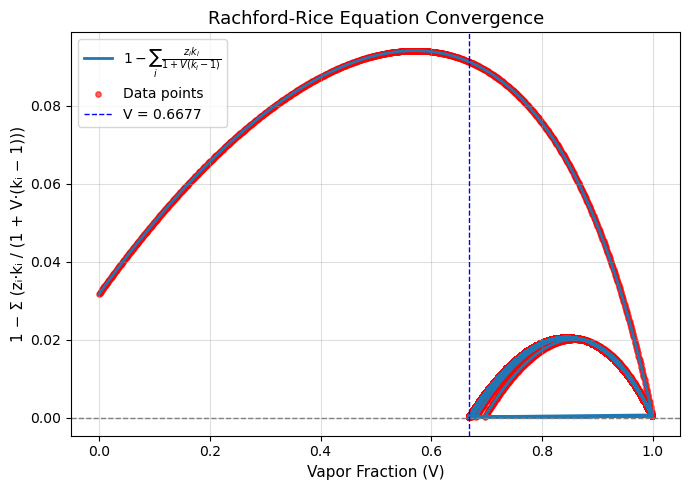

In [82]:
# (a)
temp = 338.15
x1 = 0.3
x2 = 0.4
x3 = 1-x1-x2

gamma1,gamma2,gamma3 = nrtl_ternary([x1,x2,x3],b_ij,alpha_ij,temp)
p1sat,p2sat,p3sat = vap_pressure(A1,B1,C1,temp),vap_pressure(A2,B2,C2,temp),vap_pressure(A3,B3,C3,temp)
pb = x1*gamma1*p1sat + x2*p2sat*gamma2 + x3*p3sat*gamma3
print(f"(a) bubble pressure for ternary syatem at {temp} is {pb} kpa")


# (b)
y1 = 0.3
y2 = 0.4
y3 = 1-y2-y1
p1sat,p2sat,p3sat = vap_pressure(A1,B1,C1,temp),vap_pressure(A2,B2,C2,temp),vap_pressure(A3,B3,C3,temp)

for i in range(10):

       gamma1, gamma2,gamma3 = nrtl_ternary([x1,x2,x3],b_ij,alpha_ij,temp) if i!=0 else (1,1,1)
       p_dew = 1/(y1/(gamma1*p1sat) + y2/(gamma2*p2sat) + y3/(gamma3*p3sat))
       x1 = (y1*p_dew)/(p1sat*gamma1)
       x2 = (y2*p_dew)/(p2sat*gamma2)
       x3 = 1-x1-x2
print(f"(b) dew pressure for ternary syatem at {temp} is {p_dew} kpa")


# (c)
t_flash = 333.15
p_flash = (pb + p_dew) / 2
p1sat,p2sat,p3sat = vap_pressure(A1,B1,C1,temp),vap_pressure(A2,B2,C2,temp),vap_pressure(A3,B3,C3,temp)

z1 = 0.3
z2=0.4
z3=1-z1-z2
v_value = []
summa = []

for i in range(100):
    gamma1, gamma2,gamma3 = nrtl_ternary([x1,x2,x3],b_ij,alpha_ij,temp) if i!=0 else (1,1,1)
    k1, k2,k3 = gamma1*p1sat/p_flash, gamma2*p2sat/p_flash, gamma3*p3sat/p_flash
    prev = float("inf")

    for v in np.linspace(0,1,1000):
        if abs(v-1)<=(1e-3):
            continue
        summation = z1*k1/(1+v*(k1-1)) + (z2)*k2/(1+v*(k2-1)) + z3*k3/(1+v*(k3-1)) 
        if summation>1:
            continue
        v_value.append(v)
        summa.append(1-summation)
        if abs(summation-1) < prev:
            prev = abs(summation-1)
            y1 = z1*k1/(1+v*(k1-1))
            x1 = (p_flash*y1)/(p1sat*gamma1)
            y2 = z2*k2/(1+v*(k2-1))
            x2 = (p_flash*y2)/(p2sat*gamma2)
            y3 = z3*k3/(1+v*(k3-1))
            x3 = (p_flash*y3)/(p3sat*gamma3)
            ans_v = v
        
print(f"(c) Optimal vapor fraction (V) ≈ {ans_v:.5f}")

plt.figure(figsize=(7, 5))
plt.plot(v_value, summa, label=r'$1 - \sum_i \frac{z_i k_i}{1 + V(k_i - 1)}$', linewidth=2)
plt.scatter(v_value, summa, s=15, color='red', alpha=0.6, label="Data points")

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(ans_v, color='blue', linestyle='--', linewidth=1, label=f'V = {ans_v:.4f}')

plt.title("Rachford-Rice Equation Convergence", fontsize=13)
plt.xlabel("Vapor Fraction (V)", fontsize=11)
plt.ylabel("1 − Σ (zᵢ·kᵢ / (1 + V·(kᵢ − 1)))", fontsize=11)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()



12.22

(a) Bubble temperature for ternary system = 369.443 K
(b) Dew temperature for ternary system = 345.209 K
(c) Optimal vapor fraction (V) ≈ 0.71672


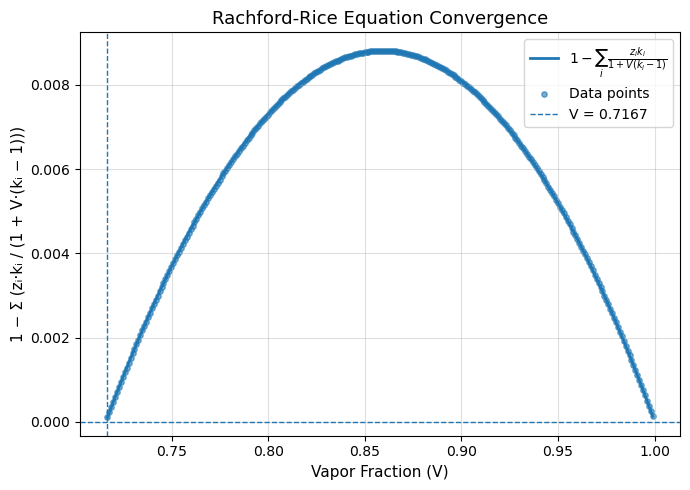

In [80]:
p = 101.33  # total system pressure (kPa or units consistent with boiling_pt/vap_pressure)


# (a) Bubble point
x1 = 0.3
x2 = 0.4
x3 = 1 - x1 - x2

# sensible initial guess: average of pure-component boiling points at p
t1sat = boiling_pt(A1, B1, C1, p)
t2sat = boiling_pt(A2, B2, C2, p)
t3sat = boiling_pt(A3, B3, C3, p)
t_avg = (t1sat + t2sat + t3sat) / 3.0

temp = t_avg
temp_old = 0.0

while abs(temp - temp_old) > 0.001:
    # saturation pressures at current temp
    p1sat = vap_pressure(A1, B1, C1, temp)
    p2sat = vap_pressure(A2, B2, C2, temp)
    p3sat = vap_pressure(A3, B3, C3, temp)

    # activity coefficients
    gamma1, gamma2, gamma3 = wilson_ternary([x1, x2, x3], [v1, v2, v3], a_ij, temp)

    # total pressure estimate using modified Raoult (correct ternary form)
    p_calc = x1 * gamma1 * p1sat + x2 * gamma2 * p2sat + x3 * gamma3 * p3sat

    # update temp using reference component (component 3) — keep your style
    temp_old = temp
    tsat = boiling_pt(A1, B1, C1, p_calc)
    t2sat = boiling_pt(A2, B2, C2, p_calc)
    t3sat = boiling_pt(A3, B3, C3, p_calc)
    temp = (t1sat + t2sat + t3sat) / 3.0

tb = temp
print(f"(a) Bubble temperature for ternary system = {tb:.3f} K")



# (b) Dew point

y1 = 0.3
y2 = 0.4
y3 = 1 - y1 - y2

# fix: compute pure-component boiling points properly
t1sat = boiling_pt(A1, B1, C1, p)
t2sat = boiling_pt(A2, B2, C2, p)
t3sat = boiling_pt(A3, B3, C3, p)
t_avg = (t1sat + t2sat + t3sat) / 3.0
temp = t_avg
temp_old = 0.0

# initialize gammas to 1 (ideal) for the first iteration
gamma1, gamma2, gamma3 = 1.0, 1.0, 1.0

while abs(temp - temp_old) > 0.001:
    # saturation pressures at current temp
    p1sat = vap_pressure(A1, B1, C1, temp)
    p2sat = vap_pressure(A2, B2, C2, temp)
    p3sat = vap_pressure(A3, B3, C3, temp)

    # dew pressure (total) from modified Raoult
    p_dew = 1.0 / (
        (y1 / (gamma1 * p1sat)) +
        (y2 / (gamma2 * p2sat)) +
        (y3 / (gamma3 * p3sat))
    )

    # obtain liquid composition corresponding to this p_dew
    x1 = y1 * p_dew / (gamma1 * p1sat)
    x2 = y2 * p_dew / (gamma2 * p2sat)
    x3 = y3 * p_dew / (gamma3 * p3sat)

    # normalize to avoid tiny rounding errors
    total_x = x1 + x2 + x3
    x1, x2, x3 = x1 / total_x, x2 / total_x, x3 / total_x

    # update activity coefficients with new liquid composition
    gamma1, gamma2, gamma3 = wilson_ternary([x1, x2, x3], [v1, v2, v3], a_ij, temp)

    # update temperature consistent with total pressure (use p_dew)
    temp_old = temp
    tsat = boiling_pt(A1, B1, C1, p_dew)
    t2sat = boiling_pt(A2, B2, C2, p_dew)
    t3sat = boiling_pt(A3, B3, C3, p_dew)
    temp = (t1sat + t2sat + t3sat) / 3.0

td = temp
print(f"(b) Dew temperature for ternary system = {td:.3f} K")



# (c) Isothermal flash (use midpoint guess for T)

t_flash = 0.5 * (tb + td)
p_flash = p
p1sat = vap_pressure(A1, B1, C1, t_flash)
p2sat = vap_pressure(A2, B2, C2, t_flash)
p3sat = vap_pressure(A3, B3, C3, t_flash)

# feed composition
z1 = 0.3
z2 = 0.2
z3 = 1 - z1 - z2

# initial guess for liquid composition use feed (or you may keep previous x)
x1 = z1
x2 = z2
x3 = z3

# prepare arrays for plotting
v_value, summa = [], []
ans_v = None
prev = float("inf")

# iterative update of k (include activity coefficients at flash T)
for i in range(100):
    if i == 0:
        gamma1, gamma2, gamma3 = 1.0, 1.0, 1.0
    else:
        gamma1, gamma2, gamma3 = wilson_ternary([x1, x2, x3], [v1, v2, v3], a_ij, t_flash)

    # K-values at flash conditions
    k1 = gamma1 * p1sat / p_flash
    k2 = gamma2 * p2sat / p_flash
    k3 = gamma3 * p3sat / p_flash

    # scan V in [0,1]
    for v in np.linspace(0.0, 1.0, 1000):
        if abs(v - 1.0) <= 1e-6:
            continue
        summation = z1 * k1 / (1 + v * (k1 - 1)) + z2 * k2 / (1 + v * (k2 - 1)) + z3 * k3 / (1 + v * (k3 - 1))
        # print(summation)
        if summation > 1:
            continue
        v_value.append(v)
        summa.append(1.0 - summation)
        if abs(summation - 1.0) < prev:
            prev = abs(summation - 1.0)
            # update y and x for best v so far
            y1 = z1 * k1 / (1 + v * (k1 - 1))
            x1 = (p_flash * y1) / (p1sat * gamma1)

            y2 = z2 * k2 / (1 + v * (k2 - 1))
            x2 = (p_flash * y2) / (p2sat * gamma2)

            y3 = z3 * k3 / (1 + v * (k3 - 1))
            x3 = (p_flash * y3) / (p3sat * gamma3)

            # normalize to be safe
            s = x1 + x2 + x3
            x1, x2, x3 = x1 / s, x2 / s, x3 / s

            ans_v = v



# safety check
if ans_v is None:
    raise RuntimeError("No feasible vapor fraction found in the scan. Check K-values and inputs.")

print(f"(c) Optimal vapor fraction (V) ≈ {ans_v:.5f}")

# plot results
plt.figure(figsize=(7, 5))
plt.plot(v_value, summa, label=r'$1 - \sum_i \frac{z_i k_i}{1 + V(k_i - 1)}$', linewidth=2)
plt.scatter(v_value, summa, s=15, alpha=0.6, label="Data points")
plt.axhline(0, linestyle='--', linewidth=1)
plt.axvline(ans_v, linestyle='--', linewidth=1, label=f'V = {ans_v:.4f}')
plt.title("Rachford-Rice Equation Convergence", fontsize=13)
plt.xlabel("Vapor Fraction (V)", fontsize=11)
plt.ylabel("1 − Σ (zᵢ·kᵢ / (1 + V·(kᵢ − 1)))", fontsize=11)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


12.23

(a) Bubble temperature for ternary system = 369.242 K
(b) Dew temperature for ternary system = 345.085 K
(c) Optimal vapor fraction (V) ≈ 0.70370


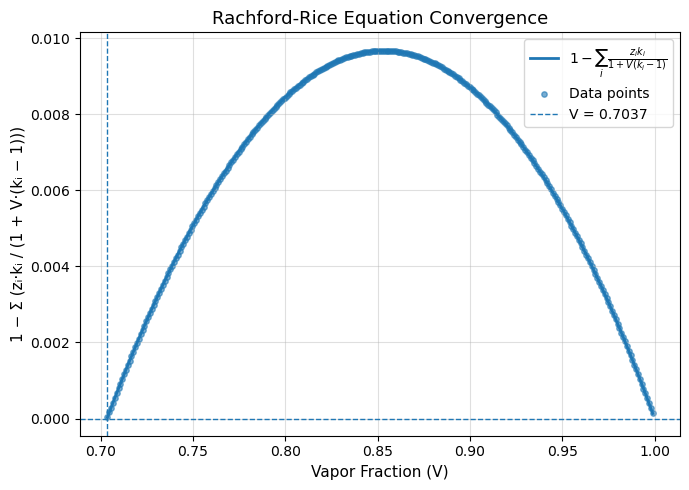

In [81]:
p = 101.33  # total system pressure (kPa or units consistent with boiling_pt/vap_pressure)


# (a) Bubble point
x1 = 0.3
x2 = 0.4
x3 = 1 - x1 - x2

# sensible initial guess: average of pure-component boiling points at p
t1sat = boiling_pt(A1, B1, C1, p)
t2sat = boiling_pt(A2, B2, C2, p)
t3sat = boiling_pt(A3, B3, C3, p)
t_avg = (t1sat + t2sat + t3sat) / 3.0

temp = t_avg
temp_old = 0.0

while abs(temp - temp_old) > 0.001:
    # saturation pressures at current temp
    p1sat = vap_pressure(A1, B1, C1, temp)
    p2sat = vap_pressure(A2, B2, C2, temp)
    p3sat = vap_pressure(A3, B3, C3, temp)

    # activity coefficients
    gamma1, gamma2, gamma3 = nrtl_ternary([x1, x2, x3], b_ij, alpha_ij, temp)

    # total pressure estimate using modified Raoult (correct ternary form)
    p_calc = x1 * gamma1 * p1sat + x2 * gamma2 * p2sat + x3 * gamma3 * p3sat

    # update temp using reference component (component 3) — keep your style
    temp_old = temp
    tsat = boiling_pt(A1, B1, C1, p_calc)
    t2sat = boiling_pt(A2, B2, C2, p_calc)
    t3sat = boiling_pt(A3, B3, C3, p_calc)
    temp = (t1sat + t2sat + t3sat) / 3.0

tb = temp
print(f"(a) Bubble temperature for ternary system = {tb:.3f} K")



# (b) Dew point

y1 = 0.3
y2 = 0.4
y3 = 1 - y1 - y2

# fix: compute pure-component boiling points properly
t1sat = boiling_pt(A1, B1, C1, p)
t2sat = boiling_pt(A2, B2, C2, p)
t3sat = boiling_pt(A3, B3, C3, p)
t_avg = (t1sat + t2sat + t3sat) / 3.0
temp = t_avg
temp_old = 0.0

# initialize gammas to 1 (ideal) for the first iteration
gamma1, gamma2, gamma3 = 1.0, 1.0, 1.0

while abs(temp - temp_old) > 0.001:
    # saturation pressures at current temp
    p1sat = vap_pressure(A1, B1, C1, temp)
    p2sat = vap_pressure(A2, B2, C2, temp)
    p3sat = vap_pressure(A3, B3, C3, temp)

    # dew pressure (total) from modified Raoult
    p_dew = 1.0 / (
        (y1 / (gamma1 * p1sat)) +
        (y2 / (gamma2 * p2sat)) +
        (y3 / (gamma3 * p3sat))
    )

    # obtain liquid composition corresponding to this p_dew
    x1 = y1 * p_dew / (gamma1 * p1sat)
    x2 = y2 * p_dew / (gamma2 * p2sat)
    x3 = y3 * p_dew / (gamma3 * p3sat)

    # normalize to avoid tiny rounding errors
    total_x = x1 + x2 + x3
    x1, x2, x3 = x1 / total_x, x2 / total_x, x3 / total_x

    # update activity coefficients with new liquid composition
    gamma1, gamma2, gamma3 = nrtl_ternary([x1, x2, x3], b_ij, alpha_ij, temp)

    # update temperature consistent with total pressure (use p_dew)
    temp_old = temp
    tsat = boiling_pt(A1, B1, C1, p_dew)
    t2sat = boiling_pt(A2, B2, C2, p_dew)
    t3sat = boiling_pt(A3, B3, C3, p_dew)
    temp = (t1sat + t2sat + t3sat) / 3.0

td = temp
print(f"(b) Dew temperature for ternary system = {td:.3f} K")



# (c) Isothermal flash (use midpoint guess for T)

t_flash = 0.5 * (tb + td)
p_flash = p
p1sat = vap_pressure(A1, B1, C1, t_flash)
p2sat = vap_pressure(A2, B2, C2, t_flash)
p3sat = vap_pressure(A3, B3, C3, t_flash)

# feed composition
z1 = 0.3
z2 = 0.2
z3 = 1 - z1 - z2

# initial guess for liquid composition use feed (or you may keep previous x)
x1 = z1
x2 = z2
x3 = z3

# prepare arrays for plotting
v_value, summa = [], []
ans_v = None
prev = float("inf")

# iterative update of k (include activity coefficients at flash T)
for i in range(100):
    if i == 0:
        gamma1, gamma2, gamma3 = 1.0, 1.0, 1.0
    else:
        gamma1, gamma2, gamma3 = nrtl_ternary([x1, x2, x3], b_ij, alpha_ij, temp)

    # K-values at flash conditions
    k1 = gamma1 * p1sat / p_flash
    k2 = gamma2 * p2sat / p_flash
    k3 = gamma3 * p3sat / p_flash

    # scan V in [0,1]
    for v in np.linspace(0.0, 1.0, 1000):
        if abs(v - 1.0) <= 1e-6:
            continue
        summation = z1 * k1 / (1 + v * (k1 - 1)) + z2 * k2 / (1 + v * (k2 - 1)) + z3 * k3 / (1 + v * (k3 - 1))
        # print(summation)
        if summation > 1:
            continue
        v_value.append(v)
        summa.append(1.0 - summation)
        if abs(summation - 1.0) < prev:
            prev = abs(summation - 1.0)
            # update y and x for best v so far
            y1 = z1 * k1 / (1 + v * (k1 - 1))
            x1 = (p_flash * y1) / (p1sat * gamma1)

            y2 = z2 * k2 / (1 + v * (k2 - 1))
            x2 = (p_flash * y2) / (p2sat * gamma2)

            y3 = z3 * k3 / (1 + v * (k3 - 1))
            x3 = (p_flash * y3) / (p3sat * gamma3)

            # normalize to be safe
            s = x1 + x2 + x3
            x1, x2, x3 = x1 / s, x2 / s, x3 / s

            ans_v = v



# safety check
if ans_v is None:
    raise RuntimeError("No feasible vapor fraction found in the scan. Check K-values and inputs.")

print(f"(c) Optimal vapor fraction (V) ≈ {ans_v:.5f}")

# plot results
plt.figure(figsize=(7, 5))
plt.plot(v_value, summa, label=r'$1 - \sum_i \frac{z_i k_i}{1 + V(k_i - 1)}$', linewidth=2)
plt.scatter(v_value, summa, s=15, alpha=0.6, label="Data points")
plt.axhline(0, linestyle='--', linewidth=1)
plt.axvline(ans_v, linestyle='--', linewidth=1, label=f'V = {ans_v:.4f}')
plt.title("Rachford-Rice Equation Convergence", fontsize=13)
plt.xlabel("Vapor Fraction (V)", fontsize=11)
plt.ylabel("1 − Σ (zᵢ·kᵢ / (1 + V·(kᵢ − 1)))", fontsize=11)
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()
